In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

In [2]:
processed_df = pd.read_pickle("data/processed_recipes.pkl")
processed_df

,name,ingredients,description,instructions,cuisine,course,diet,prep_time,categorized_prep_time,cleaned_ingredients,...,processed_name,processed_instructions,processed_description,allergen_type,processed_ingredients,combined_name_ingredients,combined_texts,prep_time_str,allergen_type_str,combined_all
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,"4 cups Indian borage (Doddapatre) , cleaned an...",Doddapatre Tambuli Recipe is a popular healing...,"To begin making the Doddapatre Tambuli, first ...",Indian,Side Dish,Vegetarian,30.0,~30 min,"[indian borage doddapatre, curd dahi yogurt, c...",...,doddapatre tambuli karpooravalli thayir pachadi,begin make doddapatre tambuli first thoroughly...,doddapatre tambuli popular healing nourish col...,[Dairy],indian borage doddapatre curd dahi yogurt cumi...,doddapatre tambuli karpooravalli thayir pachad...,doddapatre tambuli karpooravalli thayir pachad...,30.0,Dairy,doddapatre tambuli karpooravalli thayir pachad...
1,Fish Tandoori Recipe,"1 Fish , nicely washed with bones on (I used P...",Have you ever tried out fish tandoori? Trust m...,"To begin making the Fish Tandoori recipe, keep...",North Indian,Appetizer,High Protein Non Vegetarian,80.0,~1 hour 30 min,"[fish, curd dahi yogurt, onion, green chilli, ...",...,fish tandoori,begin make fish tandoori keep head tail remove...,ever try fish tandoori trust equally delicious...,[Fish and Shellfish],fish curd dahi yogurt onion green chilli tando...,fish tandoori fish curd dahi yogurt onion gree...,fish tandoori fish curd dahi yogurt onion gree...,80.0,Fish and Shellfish,fish tandoori fish curd dahi yogurt onion gree...
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,300 grams Colocasia root (Arbi) 1 Green Bell ...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,To begin making the Arbi Shimla Mirch Sabzi Re...,North Indian,Main Course,No Onion No Garlic (Sattvic),55.0,~1 hour,"[colocasia root arbi, green bell pepper capsic...",...,arbi shimla mirch sabzi colocasia capsicum sabzi,begin make arbi shimla mirch sabzi first cook ...,arbi shimla mirch sabzi variation aloo capsicu...,"[Tree Nuts and Peanuts, Legumes and Seeds]",colocasia root arbi green bell pepper capsicum...,arbi shimla mirch sabzi colocasia capsicum sab...,arbi shimla mirch sabzi colocasia capsicum sab...,55.0,"Tree Nuts and Peanuts, Legumes and Seeds",arbi shimla mirch sabzi colocasia capsicum sab...
3,Ambur Style Brinjal Curry Recipe,5 Brinjal (Baingan / Eggplant) 1 Onion 2 Tom...,Brinjal Curry is prepared in different ways in...,To begin making the Ambur Style Brinjal Curry ...,Indian,Lunch,Vegetarian,20.0,~30 min,"[brinjal baingan eggplant, onion, ginger garli...",...,ambur style brinjal curry,begin make ambur style brinjal curry add oil h...,brinjal curry prepare different way different ...,"[Tree Nuts and Peanuts, Legumes and Seeds]",brinjal baingan eggplant onion ginger garlic p...,ambur style brinjal curry brinjal baingan eggp...,ambur style brinjal curry brinjal baingan eggp...,20.0,"Tree Nuts and Peanuts, Legumes and Seeds",ambur style brinjal curry brinjal baingan eggp...
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,"1 cup Mango (Raw) , diced 2 tablespoons Jagge...",Mangalorean Mavinakayi Menasinakai Curry Recip...,To begin making Mangalorean Mavinakayi Menasin...,Mangalorean,Side Dish,Vegetarian,35.0,~45 min,"[mango raw, jaggery, turmeric powder haldi, ta...",...,mavinakayi menasinakai curry raw mango coconut...,begin make mangalorean mavinakayi menasinakai ...,mangalorean mavinakayi menasinakai curry mango...,[Legumes and Seeds],mango raw jaggery turmeric powder haldi tamari...,mavinakayi menasinakai curry raw mango coconut...,mavinakayi menasinakai curry raw mango coconut...,35.0,Legumes and Seeds,mavinakayi menasinakai curry raw mango coconut...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9491,Spinach Oats Vada Recipe,"Spinach Leaves (Palak), Chana dal (Bengal Gram...",Spinach Oats Vada Recipe is a healthy 

Train SVD model on TF-IDF and Count vectorizers and find the best number of topics using coherence scores

In [3]:
def compute_coherence_scores_svd(texts, vectorizer, num_topics_range):
    coherence_scores = []
    
    # Transform texts to TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Tokenize each text in `texts` for coherence calculation
    tokenized_texts = [text.split() for text in texts]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    # Iterate over each specified topic count
    for num_topics in num_topics_range:
        svd_model = TruncatedSVD(n_components=num_topics, random_state=42)
        svd_matrix = svd_model.fit_transform(tfidf_matrix)
        
        # Extract top words for each topic and format as list of tokens
        feature_names = vectorizer.get_feature_names_out()
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in svd_model.components_]
        
        tokenized_topics = [[word for word in topic] for topic in topics]# Coherence model requires a list of tokenized topics

        coherence_model = CoherenceModel(
            topics=tokenized_topics, 
            texts=tokenized_texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

    # Plot coherence scores
    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics")
    plt.show()
    
    # Find the best number of topics
    best_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
    print(f"Best Number of Topics: {best_num_topics} with Coherence Score: {max(coherence_scores)}")

    return coherence_scores, best_num_topics

Compare the performance of the SVD model on TF-IDF using "processed_name", "combined_name_ingredients", "combined_texts" and "combined_all" columns separately

Number of Topics: 10, Coherence Score: 0.3576535637086135
Number of Topics: 11, Coherence Score: 0.3333322304550183
Number of Topics: 12, Coherence Score: 0.34605835425207704
Number of Topics: 13, Coherence Score: 0.3011086214797662
Number of Topics: 14, Coherence Score: 0.30828524466390345
Number of Topics: 15, Coherence Score: 0.3066025820596805
Number of Topics: 16, Coherence Score: 0.3031913998502741
Number of Topics: 17, Coherence Score: 0.2976570458768203
Number of Topics: 18, Coherence Score: 0.30354860778229326
Number of Topics: 19, Coherence Score: 0.29553566476778725
Number of Topics: 20, Coherence Score: 0.2937864517551321


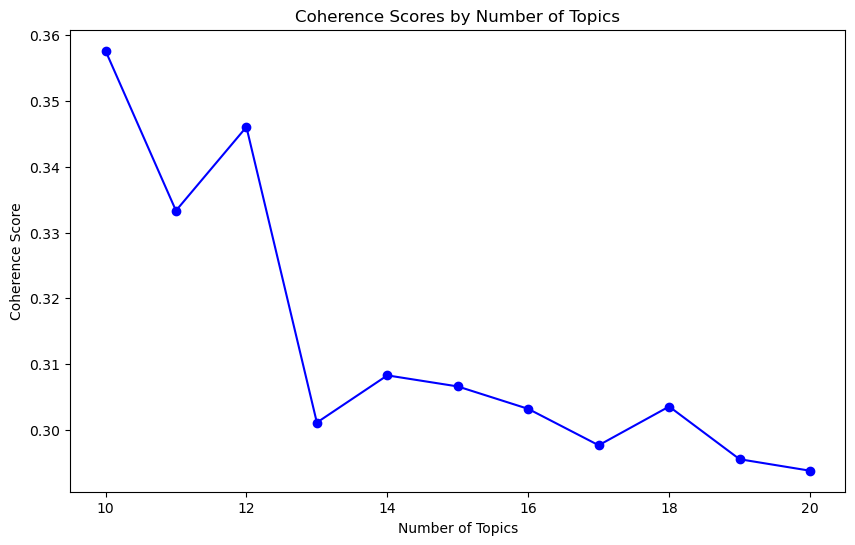

Best Number of Topics: 10 with Coherence Score: 0.3576535637086135


In [4]:
name_coherence_scores_svd_tfidf = compute_coherence_scores_svd(processed_df['processed_name'], TfidfVectorizer(), range(10, 21, 1))

Number of Topics: 1, Coherence Score: 0.6903408133729645
Number of Topics: 2, Coherence Score: 0.7948279938366802
Number of Topics: 3, Coherence Score: 0.7604074055832397
Number of Topics: 4, Coherence Score: 0.7263403675177038
Number of Topics: 5, Coherence Score: 0.6881196374747792
Number of Topics: 6, Coherence Score: 0.661249884582367
Number of Topics: 7, Coherence Score: 0.6613846019486466
Number of Topics: 8, Coherence Score: 0.6328848234841387


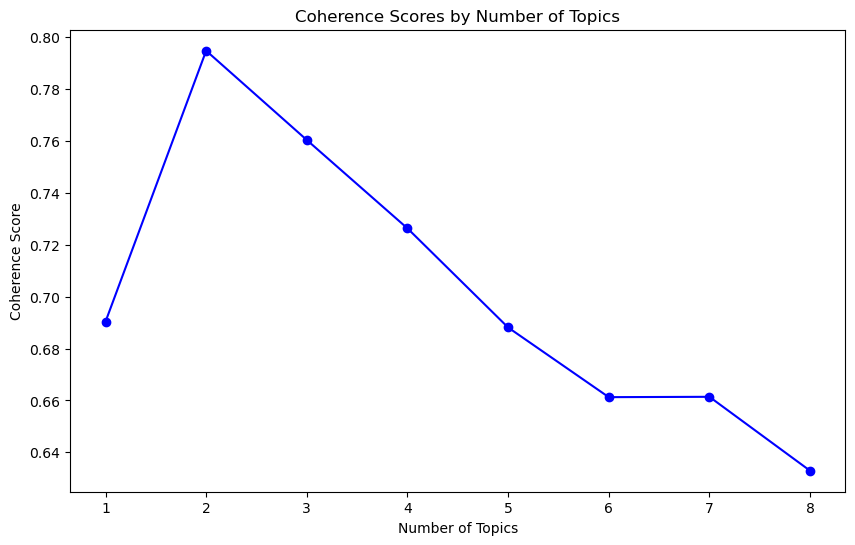

Best Number of Topics: 2 with Coherence Score: 0.7948279938366802


In [5]:
name_ingredients_coherence_scores_svd_tfidf = compute_coherence_scores_svd(processed_df['combined_name_ingredients'], TfidfVectorizer(), range(1, 9, 1))

Number of Topics: 1, Coherence Score: 0.5407311233043249
Number of Topics: 2, Coherence Score: 0.6361656579425088
Number of Topics: 3, Coherence Score: 0.642670928997246
Number of Topics: 4, Coherence Score: 0.6078051297097197
Number of Topics: 5, Coherence Score: 0.5731056054998984
Number of Topics: 6, Coherence Score: 0.5721706764317753
Number of Topics: 7, Coherence Score: 0.5471373173876001
Number of Topics: 8, Coherence Score: 0.5367475202976126


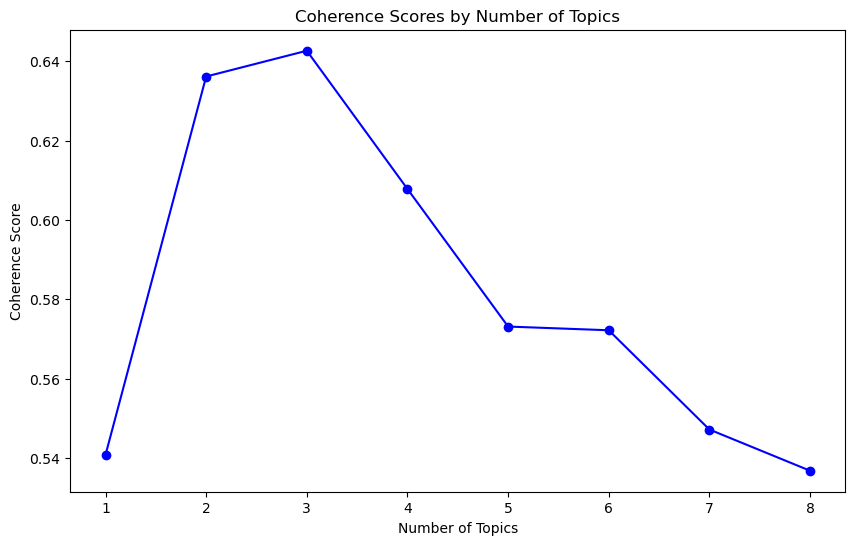

Best Number of Topics: 3 with Coherence Score: 0.642670928997246


In [6]:
texts_coherence_scores_svd_tfidf = compute_coherence_scores_svd(processed_df['combined_texts'], TfidfVectorizer(), range(1, 9, 1))

Number of Topics: 1, Coherence Score: 0.5428670502062035
Number of Topics: 2, Coherence Score: 0.6295220290032872
Number of Topics: 3, Coherence Score: 0.6410950551170483
Number of Topics: 4, Coherence Score: 0.606787170431436
Number of Topics: 5, Coherence Score: 0.584127868338012
Number of Topics: 6, Coherence Score: 0.5779367442907214
Number of Topics: 7, Coherence Score: 0.5552689298631723
Number of Topics: 8, Coherence Score: 0.5306398885009804


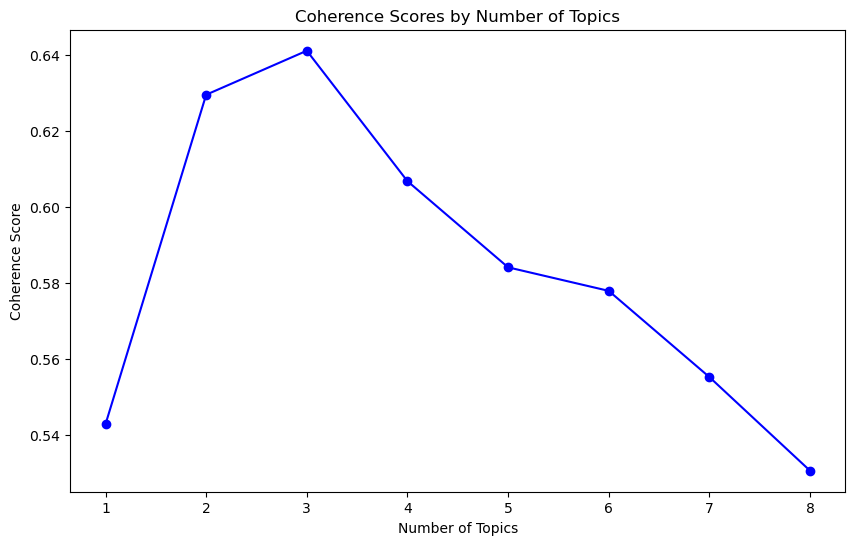

Best Number of Topics: 3 with Coherence Score: 0.6410950551170483


In [7]:
all_coherence_scores_svd_tfidf = compute_coherence_scores_svd(processed_df['combined_all'], TfidfVectorizer(), range(1, 9, 1))

Compare the performanc of the SVD on Count vectorizer "processed_name", "combined_name_ingredients", and "combined_texts" and "combined_all" columns separately

Number of Topics: 1, Coherence Score: 0.3533160027508643
Number of Topics: 2, Coherence Score: 0.31511776404354747
Number of Topics: 3, Coherence Score: 0.3793160540312525
Number of Topics: 4, Coherence Score: 0.3655742521161448
Number of Topics: 5, Coherence Score: 0.3739608292465241
Number of Topics: 6, Coherence Score: 0.42421275985765156
Number of Topics: 7, Coherence Score: 0.42835452202785973
Number of Topics: 8, Coherence Score: 0.430408301619957
Number of Topics: 9, Coherence Score: 0.40374679009280395
Number of Topics: 10, Coherence Score: 0.4028102381906895


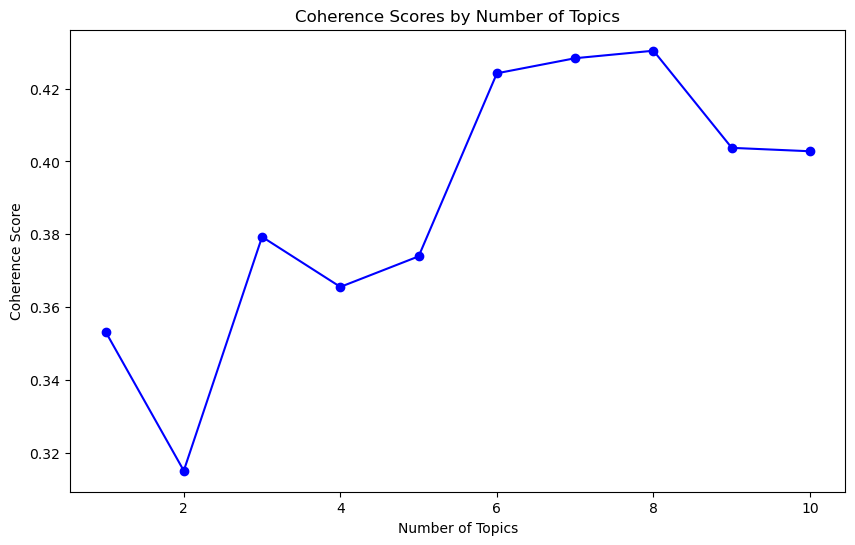

Best Number of Topics: 8 with Coherence Score: 0.430408301619957


In [8]:
name_coherence_scores_svd_countvect = compute_coherence_scores_svd(processed_df['processed_name'], CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.7199227576324339
Number of Topics: 2, Coherence Score: 0.6739900382022572
Number of Topics: 3, Coherence Score: 0.7115596805189727
Number of Topics: 4, Coherence Score: 0.7353052645614588
Number of Topics: 5, Coherence Score: 0.6882964265715039
Number of Topics: 6, Coherence Score: 0.6809017950100448
Number of Topics: 7, Coherence Score: 0.6588881668682433
Number of Topics: 8, Coherence Score: 0.6428110485569973
Number of Topics: 9, Coherence Score: 0.6388647574874962
Number of Topics: 10, Coherence Score: 0.6274691779200201


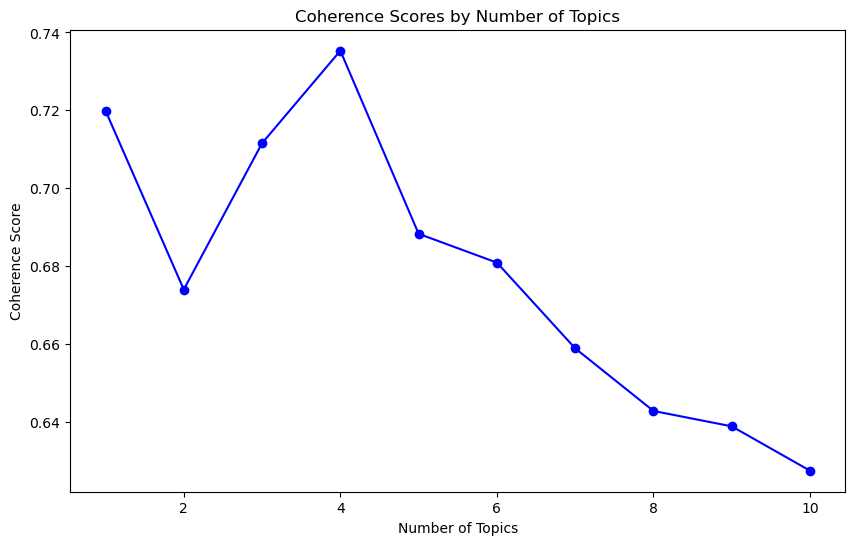

Best Number of Topics: 4 with Coherence Score: 0.7353052645614588


In [9]:
name_ingredients_coherence_scores_svd_countvect = compute_coherence_scores_svd(processed_df['combined_name_ingredients'], CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.5212533537739432
Number of Topics: 2, Coherence Score: 0.5249479223494649
Number of Topics: 3, Coherence Score: 0.535135949992329
Number of Topics: 4, Coherence Score: 0.5133441939396016
Number of Topics: 5, Coherence Score: 0.4974545537479826
Number of Topics: 6, Coherence Score: 0.5100696873911436
Number of Topics: 7, Coherence Score: 0.4902943395055493
Number of Topics: 8, Coherence Score: 0.48388627061816686
Number of Topics: 9, Coherence Score: 0.4643942350678528
Number of Topics: 10, Coherence Score: 0.45397876142433935


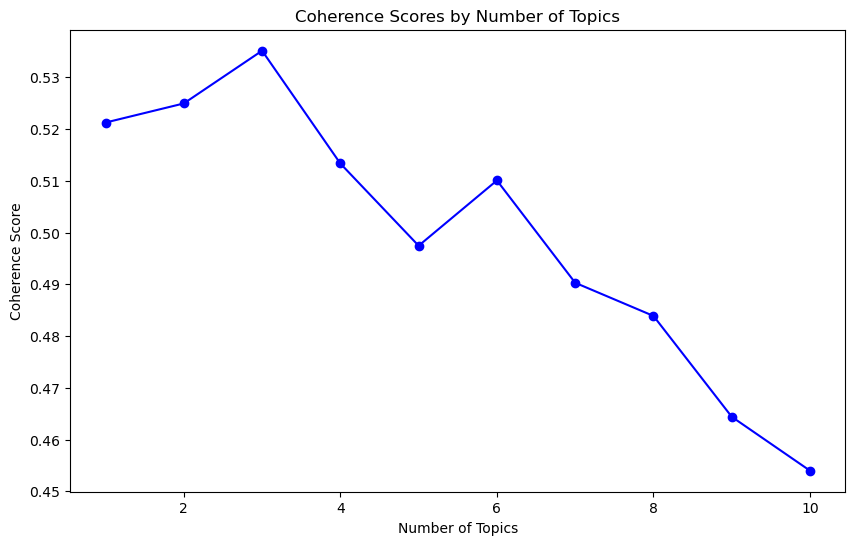

Best Number of Topics: 3 with Coherence Score: 0.535135949992329


In [10]:
texts_coherence_scores_svd_countvect = compute_coherence_scores_svd(processed_df['combined_texts'], CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.5322565641141608
Number of Topics: 2, Coherence Score: 0.5297047910391219
Number of Topics: 3, Coherence Score: 0.5360775967238048
Number of Topics: 4, Coherence Score: 0.5150758148938679
Number of Topics: 5, Coherence Score: 0.5044148122235519
Number of Topics: 6, Coherence Score: 0.5364561338452566
Number of Topics: 7, Coherence Score: 0.5128394154442202
Number of Topics: 8, Coherence Score: 0.5021420935424198
Number of Topics: 9, Coherence Score: 0.48660359048073826
Number of Topics: 10, Coherence Score: 0.46456046588812433


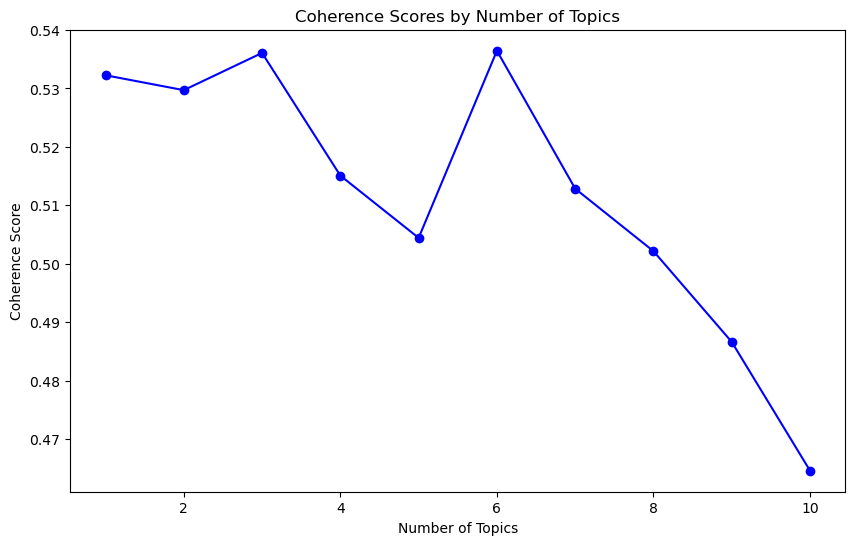

Best Number of Topics: 6 with Coherence Score: 0.5364561338452566


In [11]:
all_coherence_scores_svd_countvect = compute_coherence_scores_svd(processed_df['combined_all'], CountVectorizer(), range(1, 11, 1))

Choose the model with the highest coherence score 

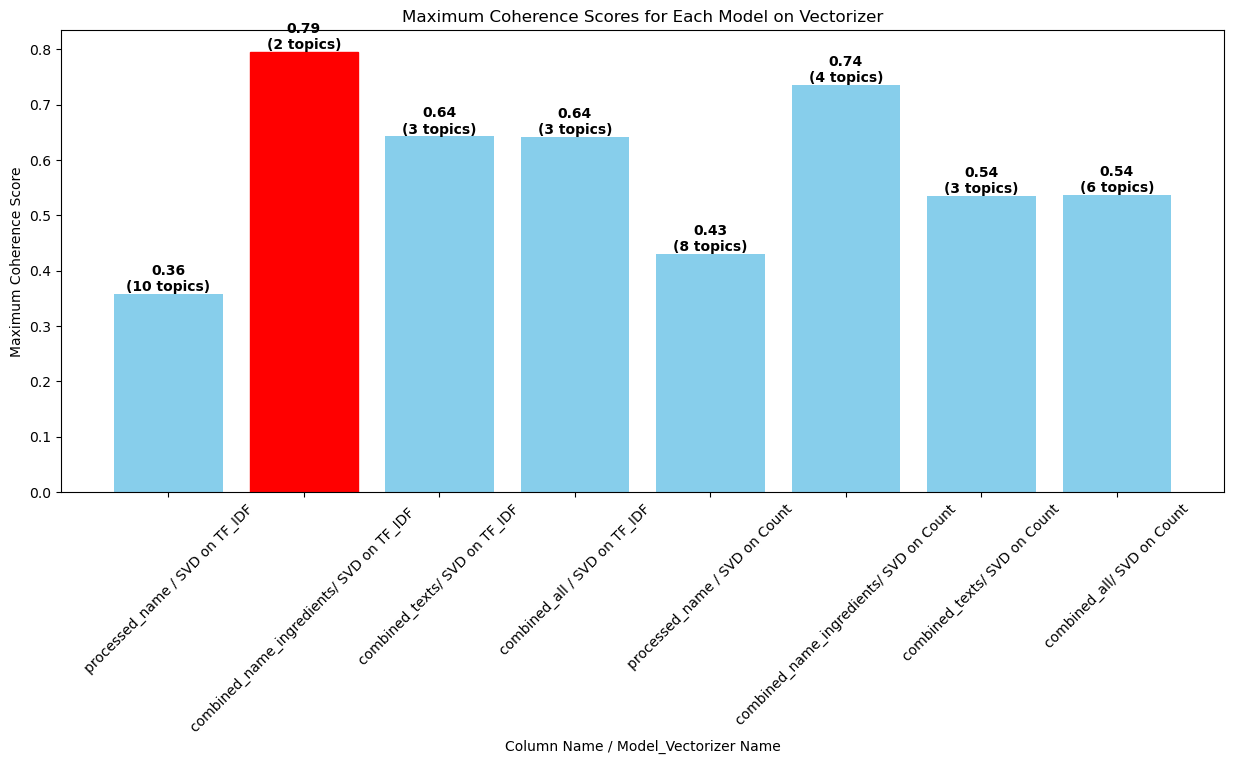

In [12]:
coherence_scores_dict = {"processed_name / SVD on TF_IDF": name_coherence_scores_svd_tfidf[0],
    "combined_name_ingredients/ SVD on TF_IDF ": name_ingredients_coherence_scores_svd_tfidf[0],
    "combined_texts/ SVD on TF_IDF": texts_coherence_scores_svd_tfidf[0], 
    "combined_all / SVD on TF_IDF": all_coherence_scores_svd_tfidf[0], 
    "processed_name / SVD on Count": name_coherence_scores_svd_countvect[0],
    "combined_name_ingredients/ SVD on Count": name_ingredients_coherence_scores_svd_countvect[0],
    "combined_texts/ SVD on Count": texts_coherence_scores_svd_countvect[0],
    "combined_all/ SVD on Count": all_coherence_scores_svd_countvect[0]}

# Best topic numbers
best_num_topics = [name_coherence_scores_svd_tfidf[1], name_ingredients_coherence_scores_svd_tfidf[1], texts_coherence_scores_svd_tfidf[1], all_coherence_scores_svd_tfidf[1],
    name_coherence_scores_svd_countvect[1], name_ingredients_coherence_scores_svd_countvect[1], texts_coherence_scores_svd_countvect[1], all_coherence_scores_svd_countvect[1]]

# Extract coherence scores and assign best topics
labels = list(coherence_scores_dict.keys())
max_scores = [max(scores) for scores in coherence_scores_dict.values()]
best_topics_for_each = [best_num_topics[i] for i in range(len(labels))]

plt.figure(figsize=(15, 6))
bars = plt.bar(labels, max_scores, color='skyblue')

# Highlight the bar with the highest coherence score
max_index = max_scores.index(max(max_scores))
bars[max_index].set_color('red')

# Annotate each bar with the coherence score and best topic count
for bar, score, topics in zip(bars, max_scores, best_topics_for_each):
    plt.text(bar.get_x() + bar.get_width() / 2, score, f'{score:.2f}\n({topics} topics)', 
             ha='center', va='bottom', fontweight='bold', color='black')

plt.xlabel("Column Name / Model_Vectorizer Name")
plt.ylabel("Maximum Coherence Score")
plt.title("Maximum Coherence Scores for Each Model on Vectorizer")
plt.xticks(rotation=45)

plt.show()